In [1]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import json, os
import random

### Parameters

In [2]:
# input file and path
ouput_path = os.getcwd() + '/output/' # folder where the results will be saved
input_file_name = 'input/pattern_1.json' # input filename
#input_file_name = 'input/pattern_2.json' # input filename


# size of border
border_x = 80 # size of canvas empty space around printing area
border_y = 80 # size of canvas empty space around printing area

# point density in lines
pt_density_in_line = 4 # how many mm the points in the lines are far apart

# outputs
create_image = True
create_video = False # to render a video, you need to install additionally the package 'ffmpeg': https://anaconda.org/conda-forge/ffmpeg

output_image_name = "pattern_prediction.png"
output_video_name = "pattern_video.avi"

### Utilities

In [3]:
def remap_unbound(input_val, in_from, in_to, out_from, out_to):
    """
    Remaps input_val from source domain to target domain.
    No clamping is performed, the result can be outside of the target domain
    if the input is outside of the source domain.
    """
    out_range = out_to - out_from
    in_range = in_to - in_from
    in_val = input_val - in_from
    val = (float(in_val) / in_range) * out_range
    out_val = out_from + val
    return out_val

In [4]:
def displayArray(data, height):
    """
    Display a 3D numpy array containing [r,g,b] values per pixel
    -
    Input /
    data = 3D numpy array
    height = maximum height to keep display ratio
    """
    plt.figure(figsize=(height * (data.shape[1] / data.shape[0]), height))
    plt.imshow(data)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(ouput_path + output_image_name) # , dpi=1200
    plt.show()
    
    
def saveArrayToImage(data, height, img_name):
    plt.figure(figsize=(height * (data.shape[1] / data.shape[0]), height))
    plt.imshow(data)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(img_name) # , dpi=1200
    plt.close() # close current image (otherwise it is retained in memory and consumes a lot of space)

### Load json file and define canvas size

In [5]:
# load json with fabrication data
json_data = None

print("Loading input json file : " + os.path.join(os.getcwd(), input_file_name))
with open(os.path.join(os.getcwd(), input_file_name), 'r') as f:
    json_data = json.load(f)
print("Loaded json file with %d entries" % len(json_data))

# --- Find points xy on json, create canvas and center the design
x_all, y_all, z_all = [], [], []
for i in range(len(json_data)):
    x, y, z = json_data[str(i)]['pt'][0], json_data[str(i)]['pt'][1], json_data[str(i)]['pt'][2]  
    x_all.append(x)
    y_all.append(y)
    z_all.append(z)
min_x, min_y = min(x_all), min(y_all)
max_x, max_y = max(x_all), max(y_all)


# size of canvas
width = int(max_x - min_x) + border_x * 2
height = int(max_y - min_y) + border_y * 2
nbrCells = width*height

print('Size of canvas:')
print('width : ', width)
print('height : ', height)


Loading input json file : D:\Google Drive\MAS teaching\2020-2021\beyond-transparency_pattern_prediction_code\input/pattern_1.json
Loaded json file with 135 entries
Size of canvas:
width :  652
height :  623


### Create color palette, and function for drawing points

In [6]:
# color palette
colors=[(4.0/255.0, 101.0/255.0, 71.0/255.0),
        (71.0/255.0, 103.0/255.0, 80.0/255.0),
        (24.0/255.0, 83.0/255.0, 65.0/255.0),
        (216.0/255.0, 193.0/255.0, 18.0/255.0), 
        (0.1, 0.1, 0.1)]

def draw_point(colorArray, X, Y, currentColor, spread=10, density=40):
    """
    colorArray: np.array with dimensions width x height x 3, holds the color per pixel
    X: x coordinate of center of circle
    Y: y coordinate of center of circle
    currentColor: index of color to be added
    spread: maximum radius of circle in which particles are spread
    density: number of particles per time
    """
    col=colors[currentColor]
    for i in range(density):
        angle=random.random() * math.pi*2
        r=random.random() * spread
        rx=r*math.cos(angle)
        ry=r*math.sin(angle)
        if int(rx)+X < width and int(ry)+Y < height:
            colorArray[int(rx)+X, int(ry)+Y, :] = col
            
            if (i%20 == 0):
                # draw a square of 4 pixels per pt
                if (int(rx)+X+1 < width):
                    colorArray[int(rx)+X+1, int(ry)+Y, :] = col
                if (int(ry)+Y+1 < height):
                    colorArray[int(rx)+X, int(ry)+Y+1, :] = col
                if (int(ry)+Y+1 < height and int(rx)+X+1 < width):
                    colorArray[int(rx)+X+1, int(ry)+Y+1, :] = col
        else: 
            pass
#             print('Attention, pixel out of bounds : ', int(rx)+X, int(ry)+Y)

### Main

In [7]:
# --- Create canvas and paint background color
rgb_array = np.array([[1.0,1.0,1.0] for i in range(nbrCells)]).reshape(width, height , 3) # 0.8,0.8,0.8

z0 = -542

# --- Color canvas : Here is where it all happens
count = 0
for i in range(len(json_data)):
    entry_data = json_data[str(i)]
    
    # get parameters for current entry
    x, y, z = x_all[i], y_all[i], z_all[i]    
    x, y, z = x - min_x + border_x, y - min_y + border_y, z - z0 # translate to fit the canvas 
    color = json_data[str(i)]['color']
    velocity = json_data[str(i)]['v']
    
    # --- printing a line
    if (i<len(json_data)-1):
    
        extruder = entry_data['extruder']
        if extruder:
            x_next = json_data[str(i+1)]['pt'][0] - min_x + border_x
            y_next = json_data[str(i+1)]['pt'][1] - min_y + border_y
            z_next = json_data[str(i+1)]['pt'][2] - z0
            
            # velocity determines the density of the spread
            density = 50.0 * 130.0 / float(velocity)
            density = int(density)
            density = max(10, min(180, density))            

            line_length = math.sqrt((x-x_next)**2 + (y-y_next)**2)
            number_of_pts = max(3, int(line_length/pt_density_in_line))
            
            # create points that draw the line
            for k in range(number_of_pts):
                path_fraction = float(k)/float(number_of_pts) 
                x_pt = x * (1-path_fraction) + x_next * (path_fraction)
                y_pt = y * (1-path_fraction) + y_next * (path_fraction)
                z_pt = z * (1-path_fraction) + z_next * (path_fraction)

                # z value determines the radius of the spread
                spread = 2.5 + z_pt*0.5 
                if k%15 == 0:
                    spread = 3*spread
                
                if k%20 == 0:
                    draw_point(rgb_array, int(x_pt), int(y_pt), 4, spread, density) # black dots
                else:
                    draw_point(rgb_array, int(x_pt), int(y_pt), color, spread, density)
                    
                    
                
                # ---> ANIMATION
                if create_video: 
                    saveArrayToImage(rgb_array, 12, ouput_path + '/anim/img_%04d.png' % count) # '/anim/img_%04d.png' % count
                    count += 1
                # ANIMATION <---

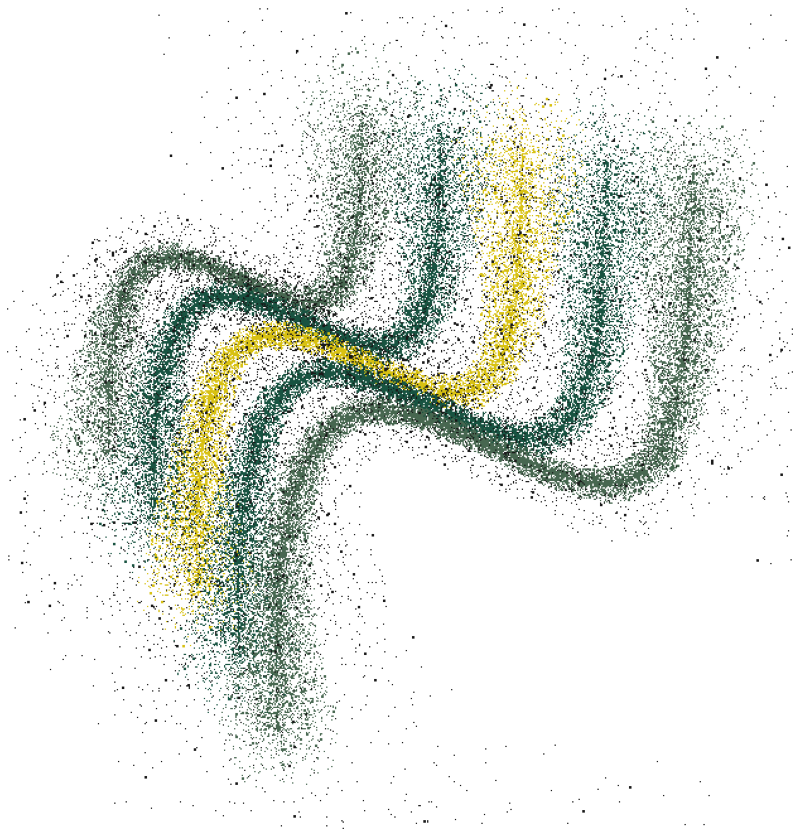

In [8]:
if create_image:
    displayArray(rgb_array, 12)

In [9]:
if create_video:
    # connect images into a video file: video.avi
    import subprocess
    frames_per_second = 48
    subprocess.call(["ffmpeg","-y","-r",str(frames_per_second),"-i", "output/anim/img_%04d.png","-vcodec","mpeg4", "-qscale","5", "-r", str(frames_per_second), ouput_path + output_video_name])
    
    #empty directory /anim/ from the images after creating the video
    for filename in os.listdir(ouput_path + '/anim/'):
        file = os.path.join(ouput_path + '/anim/', filename)
        if os.path.isfile(file) or os.path.islink(file):
            os.remove(file)